In [2]:
import numpy as np
import awkward as ak
from coffea.nanoaod import NanoEvents
from uproot_methods import TLorentzVectorArray
import time
from uproot_methods import TVector2Array

In [6]:
!ls data/NanoAOD_files/scheme4_nano.root
fname = "data/NanoAOD_files/scheme4_nano.root"

data/NanoAOD_files/scheme4_nano.root


- Read event tree

In [7]:
events = NanoEvents.from_file(fname)

In [8]:
print("Total {0} number of events".format(len(events)))

Total 17150 number of events


 - Particle branch to array

In [9]:
Electron = events.Electron
Muon = events.Muon
Photon = events.Photon
MET = events.MET

 ### Particle Selection
 - MET > 20 GeV
 - PT$_{e,\gamma}$ > 20 GeV,  |$\eta_{l,\gamma}$| < 2.5,
 - Electron cutbased_id > 1 ( Loose )
 - Photon cutbased_id > 0 ( Loose )

#### How to apply cut in array-based method: Mask  
arr1 = [1,1,2,1]  
arr1_cut_mask = arr1 > 1  
> [ False, False, True, False ]  
  
Sel_arr1 = arr1[arr1_cut_mask]  
> [ 2 ]  

In [10]:
def Particle_Selection(MET,Electron,Photon):
    MET_mask = MET.pt > 20
    Electron_mask = (Electron.pt >20) & (np.abs(Electron.eta) < 2.5) & (Electron.cutBased > 1) 
    #Photon_mask = (Photon.pt > 20 ) & (np.abs(Photon.eta) < 2.5)  & (Photon.genPartFlav == 1) & (Photon.cutBasedBitmap > 0)
    
    Photon_mask = (Photon.pt > 20 ) & (np.abs(Photon.eta) < 2.5)  & (Photon.cutBasedBitmap > 0)
    return(MET_mask,Electron_mask,Photon_mask)

In [11]:
MET_mask,Electron_mask,Photon_mask = Particle_Selection(MET,Electron,Photon)

In [12]:
Ele_Sel_mask = Electron[Electron_mask].counts > 2
Pho_Sel_mask = Photon[Photon_mask].counts > 0

Event_mask = Ele_Sel_mask & Pho_Sel_mask 

In [14]:
print(" - Electron Cut Eff: {0} %".format(
    np.sum(Electron_mask.content) /  len(Electron_mask.content) * 100
    ))

print(" - Photon Cut Eff: {0} %".format(
    np.sum(Photon_mask.content) /  len(Photon_mask.content) * 100
    ))

print(" - Event Selection Eff: {0}%  | number of selected events: {1}".format(
    np.sum(Event_mask) /  len(Event_mask) * 100, np.sum(Event_mask)
    ))

 - Electron Cut Eff: 55.18212211859933 %
 - Photon Cut Eff: 62.57258490234031 %
 - Event Selection Eff: 2.1749271137026236%  | number of selected events: 373


### Event Selection

In [15]:
Ele_channel_events = events[Event_mask]

In [16]:
Ele = Ele_channel_events.Electron
Pho = Ele_channel_events.Photon

In [17]:
Ele

<ElectronArray [[<Electron 78> <Electron 79> <Electron 80>] [<Electron 151> <Electron 152> <Electron 153>] [<Electron 259> <Electron 260> <Electron 261>] ... [<Electron 22494> <Electron 22495> <Electron 22496> <Electron 22497>] [<Electron 22637> <Electron 22638> <Electron 22639> <Electron 22640> <Electron 22641>] [<Electron 22689> <Electron 22690> <Electron 22691> <Electron 22692>]] at 0x7f86d18c6b20>

 ### Choose different sign and highest-PT Electron pair
 - distincts() makes all possible particle pairs  
 - .i0 and .i1 choose each of paritlce pair
 - ele_pairs.i0+ele_pairs.i1 : Lorentz Sum

In [18]:
# All possible pairs of Electron in each event
ele_pairs = Ele.distincts()

# TLorentz vector sum of ele_pairs
diele = ele_pairs.i0+ele_pairs.i1

# Choose different sign pair ( erase same-sign paris using cut mask)
diffsign_diele =  diele[diele.charge==0]

# choose maximum pt pairs ( choose maximum-PT Electron paris)
leading_diffsign_diele = diffsign_diele[diffsign_diele.pt.argmax()]

In [21]:
## For study
print(ele_pairs)
print(" ")
print(ele_pairs.i0)
print(" ")
print(ele_pairs.i1)
print(" ")
print(diffsign_diele)

[[(<Electron 78>, <Electron 79>) (<Electron 78>, <Electron 80>) (<Electron 79>, <Electron 80>)] [(<Electron 151>, <Electron 152>) (<Electron 151>, <Electron 153>) (<Electron 152>, <Electron 153>)] [(<Electron 259>, <Electron 260>) (<Electron 259>, <Electron 261>) (<Electron 260>, <Electron 261>)] ... [(<Electron 22494>, <Electron 22495>) (<Electron 22494>, <Electron 22496>) (<Electron 22494>, <Electron 22497>) (<Electron 22495>, <Electron 22496>) (<Electron 22495>, <Electron 22497>) (<Electron 22496>, <Electron 22497>)] [(<Electron 22637>, <Electron 22638>) (<Electron 22637>, <Electron 22639>) (<Electron 22637>, <Electron 22640>) ... (<Electron 22639>, <Electron 22640>) (<Electron 22639>, <Electron 22641>) (<Electron 22640>, <Electron 22641>)] [(<Electron 22689>, <Electron 22690>) (<Electron 22689>, <Electron 22691>) (<Electron 22689>, <Electron 22692>) (<Electron 22690>, <Electron 22691>) (<Electron 22690>, <Electron 22692>) (<Electron 22691>, <Electron 22692>)]]
 
[[<Electron 78> <El

In [22]:
Mee = leading_diffsign_diele.mass.content ## contet -> Flatten array 

In [99]:
## --- Not now ...
#def delta_r(pair):
#    return pair.i0.delta_r(pair.i1)

#JselE_pair = Jet.cross(Sel_Electron,nested=True)
#dr_JselE_mask = (delta_r(JselE_pair) > 0.3).any()

#JselA_pair = Jet.cross(Sel_Photon,nested=True)
#dr_JselA_mask = (delta_r(JselA_pair)>0.3).any()


#Jet_mask = Jet_basic_mask & dr_JselE_mask & dr_JselA_mask

### Visualization

In [23]:
import mplhep as hep
import matplotlib.pyplot as plt

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


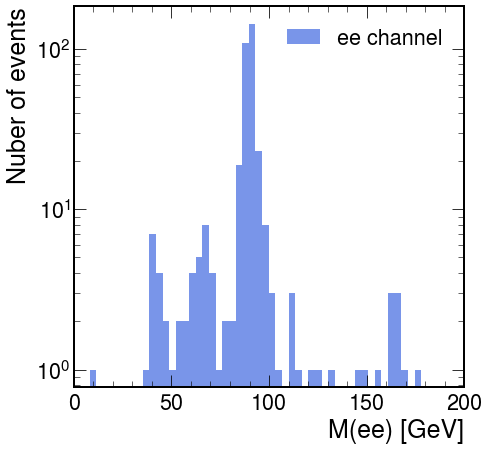

In [24]:
plt.figure(figsize=(7, 7))
plt.style.use(hep.style.CMS)
plt.hist(Mee,bins=50,color='royalblue',alpha=0.7,label='ee channel')
plt.xlim(0,200)
plt.xlabel('M(ee) [GeV]',fontsize=25)
plt.ylabel('Nuber of events',fontsize=25)
plt.yscale('log')
plt.legend()